In [1]:
import pandas as pd
import numpy as np
import ast

from keypoint_cleaner import interpolate_frames
from data_visualization import draw_random_frame

PATH_ACTIONS_FILTERED               = "../Data/tmp/actions_filtered.csv"
PATH_METRICS                        = "../../Models/YOLO/metrics.csv"
PATH_KEYPOINTS                      = "../Data/Unprocessed/keypoints.csv"
PATH_KEYPOINTS_FILTERED             = "../Data/tmp/keypoints_filtered.csv"

LOW_CONFIDENCE_THRESHOLD            = 0.6

In [2]:
df_metrics = pd.read_csv(PATH_METRICS)

total_expected_frames = df_metrics["expected"].sum()
total_actual_frames = df_metrics["actual"].sum()
total_coverage = total_actual_frames / total_expected_frames

print(df_metrics[df_metrics["expected"] != df_metrics["actual"]])
print("")

print("Expected frames: ", total_expected_frames)
print("Actual frames:   ", total_actual_frames)
print(f"Coverage:         {total_coverage*100:.2f}%")

    fencer  action_id  start_frame  end_frame  expected  actual   coverage
29    LEFT        170           22         29         8       7  87.500000
41    LEFT        209           22         29         8       7  87.500000
44   RIGHT        219           24         30         7       5  71.428571
65   RIGHT        142           30         37         8       6  75.000000
67   RIGHT        208           29         36         8       6  75.000000
..     ...        ...          ...        ...       ...     ...        ...
430  RIGHT        298           27         44        18      17  94.444444
439  RIGHT        284           16         22         7       6  85.714286
441  RIGHT        280           16         21         6       5  83.333333
446   LEFT        316           28         35         8       7  87.500000
447  RIGHT        317           24         34        11       9  81.818182

[68 rows x 7 columns]

Expected frames:  4247
Actual frames:    4139
Coverage:         97.46%


In [3]:
df_keypoints = pd.read_csv(PATH_KEYPOINTS)

df_keypoints["box"] = df_keypoints["box"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

df_keypoints["keypoints"] = df_keypoints["keypoints"].apply(
    lambda x: [tuple(p) for p in ast.literal_eval(x)] if isinstance(x, str) else x
)

print(df_keypoints)

               file fencer  frame                     box  confidence  \
0     1/10_Left.mp4   LEFT     23    (749, 585, 885, 791)    0.874569   
1     1/10_Left.mp4   LEFT     24    (749, 590, 916, 791)    0.886595   
2     1/10_Left.mp4   LEFT     25    (748, 596, 941, 791)    0.864050   
3     1/10_Left.mp4   LEFT     26    (748, 604, 958, 793)    0.908107   
4     1/10_Left.mp4  RIGHT     21  (1067, 574, 1219, 788)    0.931627   
...             ...    ...    ...                     ...         ...   
4242   6/9_Left.mp4  RIGHT     40   (995, 550, 1194, 773)    0.943588   
4243   6/9_Left.mp4  RIGHT     41   (973, 550, 1201, 771)    0.895878   
4244   6/9_Left.mp4  RIGHT     42   (976, 553, 1207, 769)    0.909296   
4245   6/9_Left.mp4  RIGHT     43   (984, 556, 1211, 770)    0.949838   
4246   6/9_Left.mp4  RIGHT     44  (1001, 561, 1212, 769)    0.810839   

                                              keypoints  
0     [(819.49, 613.49), (824.04, 610.67), (816.23, ...  
1     [

In [4]:
df_filtered = pd.read_csv(PATH_ACTIONS_FILTERED)

df_merged = df_keypoints.merge(df_filtered, on=["file", "fencer"], how="left")
df_merged = df_merged[
    (df_merged["frame"] >= df_merged["start_frame"]) &
    (df_merged["frame"] <= df_merged["end_frame"])
]

df_merged = df_merged[["file", "fencer", "action_id", "action", "frame", "start_frame", "end_frame", "box", "keypoints", "confidence"]].reset_index(drop=True)
print(df_merged)

               file fencer  action_id          action  frame  start_frame  \
0     1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     23           23   
1     1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     24           23   
2     1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     25           23   
3     1/10_Left.mp4   LEFT          0    ATTACK_LUNGE     26           23   
4     1/10_Left.mp4  RIGHT          1    ATTACK_LUNGE     21           21   
...             ...    ...        ...             ...    ...          ...   
4202   6/9_Left.mp4  RIGHT        468  ATTACK_COUNTER     40           38   
4203   6/9_Left.mp4  RIGHT        468  ATTACK_COUNTER     41           38   
4204   6/9_Left.mp4  RIGHT        468  ATTACK_COUNTER     42           38   
4205   6/9_Left.mp4  RIGHT        468  ATTACK_COUNTER     43           38   
4206   6/9_Left.mp4  RIGHT        468  ATTACK_COUNTER     44           38   

      end_frame                     box  \
0            26    (749, 585, 88

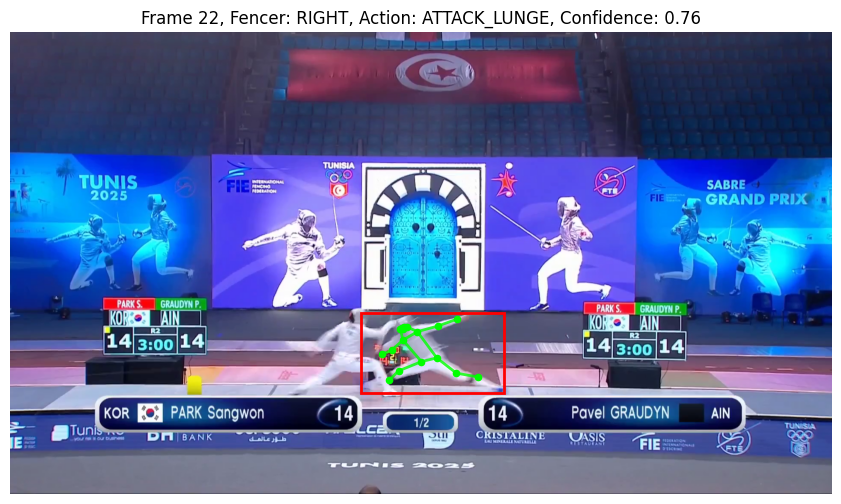

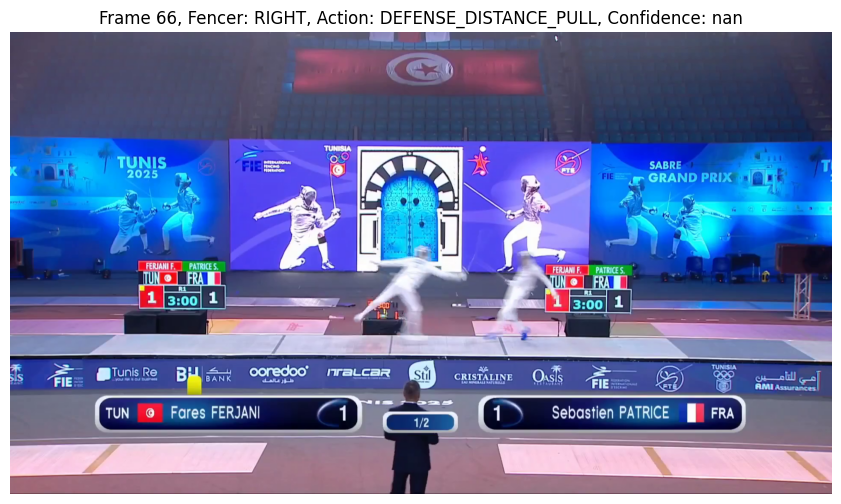

In [5]:
df_missing = df_merged[df_merged["confidence"].isna()]

draw_random_frame(df_merged)
draw_random_frame(df_missing)

count    4101.000000
mean        0.822732
std         0.102893
min         0.049223
25%         0.775196
50%         0.837118
75%         0.886749
max         0.970294
Name: confidence, dtype: float64

Number of low confidence frames:  66


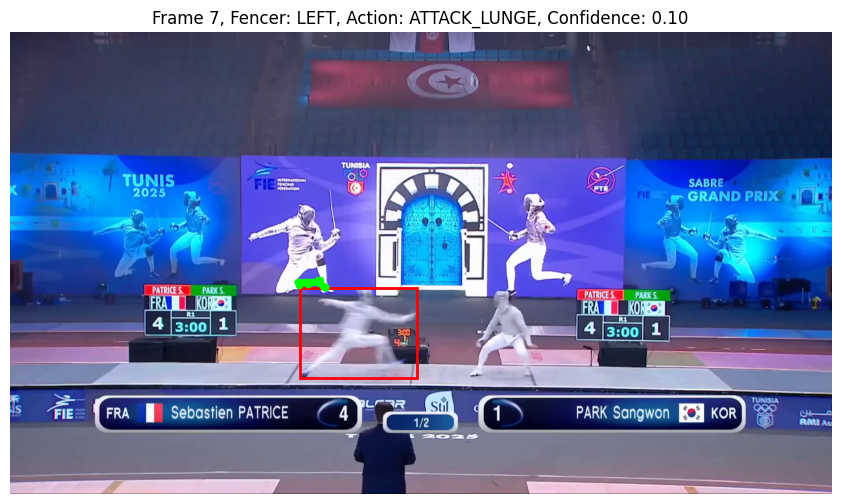

In [6]:
confidences = df_merged["confidence"]
df_low_confidence = df_merged[confidences < LOW_CONFIDENCE_THRESHOLD]

print(confidences.describe())
print("")
print("Number of low confidence frames: ", len(df_low_confidence))

sample = df_low_confidence.sample(min(10, len(df_low_confidence)), random_state=42)
sample_confidences = confidences.loc[sample.index]

draw_random_frame(sample)

/tmp/ipykernel_38427/3927094336.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_min_confidence = df_reduced[confidences < LOW_CONFIDENCE_THRESHOLD + 0.1]


Number of min confidence frames:  129



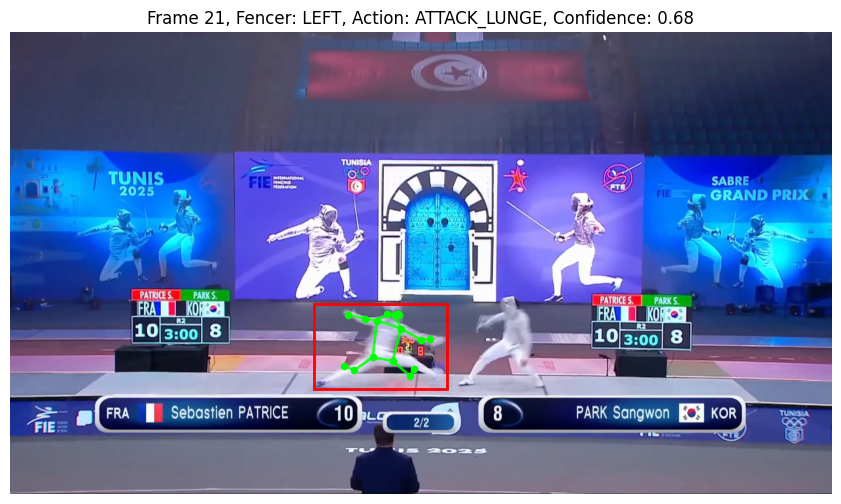

In [7]:
df_reduced = df_merged[confidences >= LOW_CONFIDENCE_THRESHOLD]
df_min_confidence = df_reduced[confidences < LOW_CONFIDENCE_THRESHOLD + 0.1]

print("Number of min confidence frames: ", len(df_min_confidence))
print("")

sample = df_min_confidence.sample(min(10, len(df_min_confidence)), random_state=42)
sample_confidences = confidences.loc[sample.index]

draw_random_frame(sample)

In [8]:
df_interpolated, stats = interpolate_frames(df_reduced)

expected_frame_difference = stats["interpolated_frames"] + stats["copied_frames"] - stats["dropped"]
actual_frame_difference = len(df_interpolated) - len(df_reduced)

print("==== Interpolation Statistics ====")
print(stats.to_string())
print("")

print("Frame count before interpolation: ", len(df_reduced))
print("Frame count after interpolation:  ", len(df_interpolated))
print("")

print("Expected frame count difference: ", expected_frame_difference)
print("Actual frame count difference:   ", actual_frame_difference)
print("")

==== Interpolation Statistics ====
processed              466
dropped                  1
skipped                373
interpolated            92
interpolated_frames    112
copied_frames           56

Frame count before interpolation:  4035
Frame count after interpolation:   4202

Expected frame count difference:  167
Actual frame count difference:    167



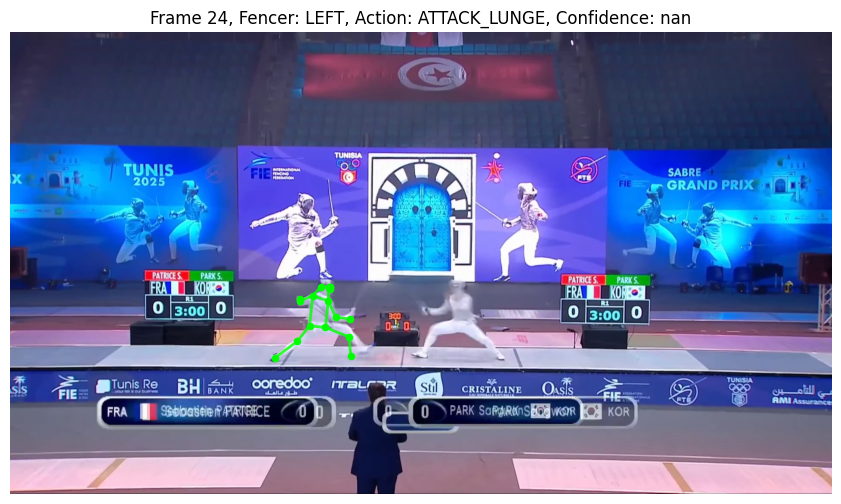

In [9]:
df_interpolated_only = df_interpolated[df_interpolated["confidence"].isna()]
draw_random_frame(df_interpolated_only)

In [10]:
def keypoints_to_tuples(kp):
    arr = np.array(kp, dtype=float)
    return [(float(x), float(y)) for x, y in arr]

df_interpolated["keypoints"] = df_interpolated["keypoints"].apply(keypoints_to_tuples)

df_interpolated = df_interpolated[["file", "fencer", "action_id","action", "frame", "start_frame", "end_frame", "box", "confidence", "keypoints"]].reset_index(drop=True)
df_interpolated.to_csv(PATH_KEYPOINTS_FILTERED, index=False)